Part 1:

Instructions for part 1:
In this part use the same dataset as you used for the first two homework.

1- Pick two frequencies of 5 Hz and 25 Hz and electrode of Cz.
Then perform complex Morlet wavelet convolution and filter-Hilbert using those two frequencies as the peak/ center frequencies for all trials.
Plot the resulting power and the bandpass-filtered signal (that is, the real component of the analytic signal) from each method (you need to plot the average of all the trials). 
Describe some similarities and differences between the results of the two time-frequency decomposition methods.

Note:
 You need to generate the analytic form of the signal similar to what “hilbert” Matlab
function does.

 Do not use any pre-written Matlab function (e.g., “hilbert’) for generating your results.

Import necessary functions and libraries.

In [343]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert

%matplotlib inline

In [344]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

In [345]:
EEGdata.shape, EEGchanlocslabels[47], EEGchanlocslabels.shape, EEGpnts

((64, 640, 99), array(['Cz'], 
       dtype='<U2'), (64,), 640)

In [346]:
from firls import firls
#this is a Python firls() implementation taken from
#http://projects.scipy.org/scipy/attachment/ticket/648/designtools.py

In [347]:
# Part 1:
# Instructions for part 1:
# In this part use the same dataset as you used for the first two homework.
# 1- Pick two frequencies of 5 Hz and 25 Hz and electrode of Cz. # channel 46
# Then perform complex Morlet wavelet convolution and filter-Hilbert 
# using those two frequencies as the peak/ center frequencies for all trials.
# Plot the resulting power and the bandpass-filtered signal (that is, the real component of the analytic signal) 
# from each method (you need to plot the average of all the trials). 
# Describe some similarities and differences between the results of the two time-frequency decomposition methods.
# Note:
#  You need to generate the analytic form of the signal similar to what “hilbert” Matlab
# function does.
#  Do not use any pre-written Matlab function (e.g., “hilbert’) for generating your results.

# first, filter data (filter mechanisms will be explained more below; for now, focus on 
# using the phases from the Hilbert transform to test whether the matrix input was correct)
from scipy.stats.mstats import zscore # normalizing with zero-mean, uni-vari/ std

nyquist = EEGsrate/2 #hz
center_freq = 5.0 #in hz
filter_frequency_spread = 2.0 #Hz, +- center frequency

#create wavelet window
time = np.arange(-1000/EEGsrate/10.,1000/EEGsrate/10. + 1/EEGsrate,1/EEGsrate)

# filter_frequency_spread == num cycles
scale = (filter_frequency_spread/(2*pi*center_freq))
waveletweights = exp(1j * 2*pi*center_freq * time) * exp(-(time**2) / (2*(scale**2)))

#construct filter kernel
transition_width = 0.2

ffrequencies = np.array([ 0, 
                         (1-transition_width)*(center_freq-filter_frequency_spread),
                         (center_freq-filter_frequency_spread),
                         (center_freq+filter_frequency_spread), 
                         (1+transition_width)*(center_freq+filter_frequency_spread),
                         nyquist ])/nyquist;

# firls: filter infinite response with least square
idealresponse = np.array([0,0,1,1,0,0])
filterweights = firls(len(time)-1, ffrequencies, idealresponse) #use firls script described above
hilbertweights = hilbert(filterweights)

# normalized
waveletweights = zscore(waveletweights)
filterweights = zscore(filterweights)
hilbertweights = zscore(hilbertweights)

# compute its power spectrum after normalization
fft_wavelet = absolute(fft(waveletweights))
fft_wavelet /= np.max(fft_wavelet) #normalized to one for visual comparison case

fft_filter = absolute(fft(filterweights))
fft_filter /= np.max(fft_filter) #normalized to one for visual comparison case

fft_hilbert = absolute(fft(hilbertweights))
fft_hilbert /= np.max(fft_hilbert) #normalized to one for visual comparison case

# hz = np.linspace(0, nyquist, len(time)) 
hz_filter = np.linspace(0, nyquist, (len(time)/2) + 1) 


# apply the filter kernal to the data to obtain the band-pass filtered signal
filtered_data = zeros([EEGpnts, EEGtrials])
hilbert_data = zeros([EEGpnts, EEGtrials])
wavelet_data = zeros([EEGpnts, EEGtrials])

# filtered data using convolution or convolved data using filter
for idx in range(EEGtrials):
    filtered_data[:, idx] = np.convolve(a=filterweights, mode='same', v=EEGdata[47, :, idx])
    hilbert_data[:, idx] = np.convolve(a=hilbertweights, mode='same', v=EEGdata[47, :, idx])
    wavelet_data[:, idx] = np.convolve(a=waveletweights, mode='same', v=EEGdata[47, :, idx])

# Average over all the trials
filtered_data_mean = filtered_data.mean(axis=1)
hilbert_data_mean = hilbert_data.mean(axis=1)
wavelet_data_mean = wavelet_data.mean(axis=1)

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]
/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


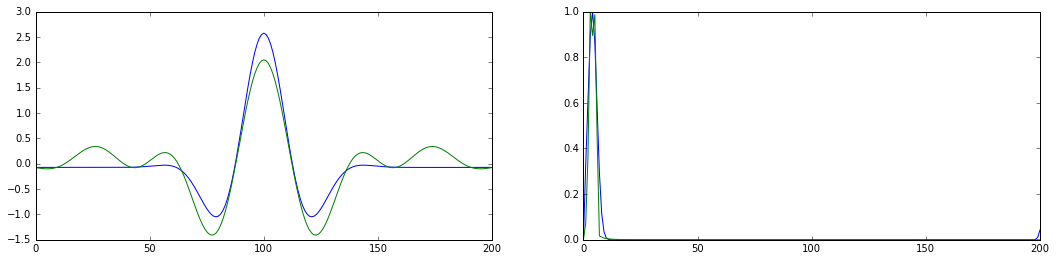

In [348]:
plt.figure(figsize=(18, 9))
plt.subplot(221)
plt.plot(waveletweights);
# plt.plot(filterweights);
plt.plot(hilbertweights);

plt.subplot(222)
plt.plot(fft_wavelet);
# plt.plot(fft_filter);
plt.plot(fft_hilbert);

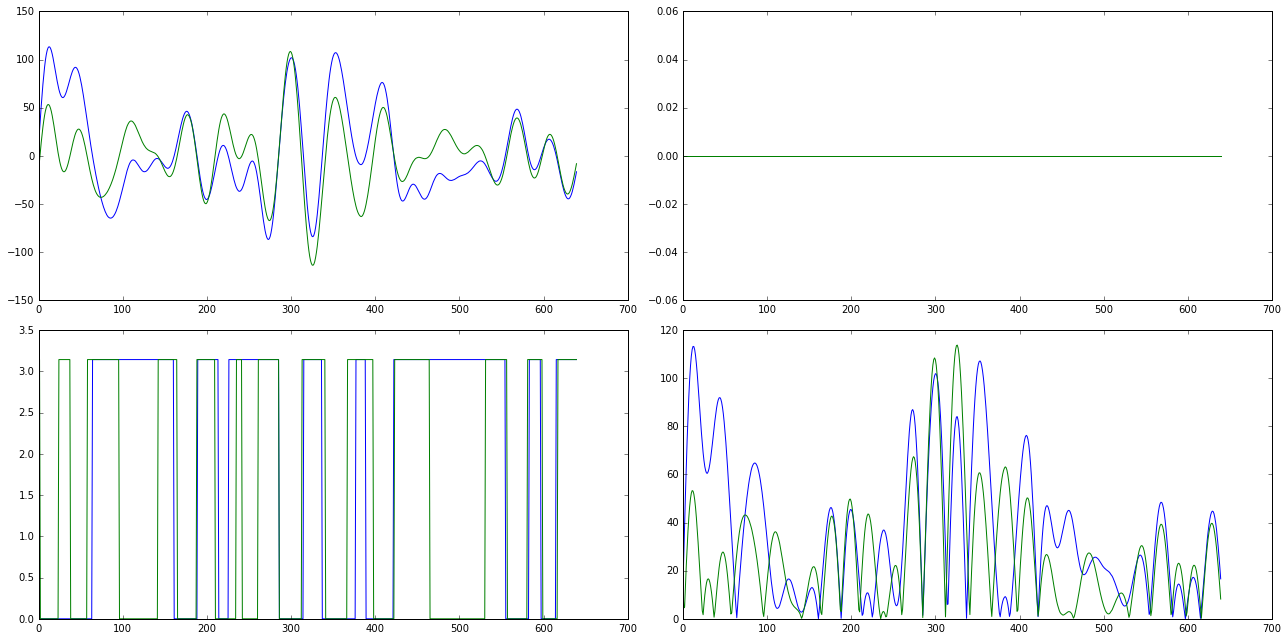

In [349]:
plt.figure(figsize=(18, 9))
plt.subplot(221)
plt.plot(real(wavelet_data_mean));
# plt.plot(real(filtered_data_mean));
plt.plot(real(hilbert_data_mean));

plt.subplot(222)
plt.plot(imag(wavelet_data_mean));
# plt.plot(imag(filtered_data_mean));
plt.plot(imag(hilbert_data_mean));

plt.subplot(223)
plt.plot(angle(wavelet_data_mean));
# plt.plot(angle(filtered_data_mean));
plt.plot(angle(hilbert_data_mean));

plt.subplot(224)
plt.plot(absolute(wavelet_data_mean));
# plt.plot(absolute(filtered_data_mean));
plt.plot(absolute(hilbert_data_mean));

plt.tight_layout()

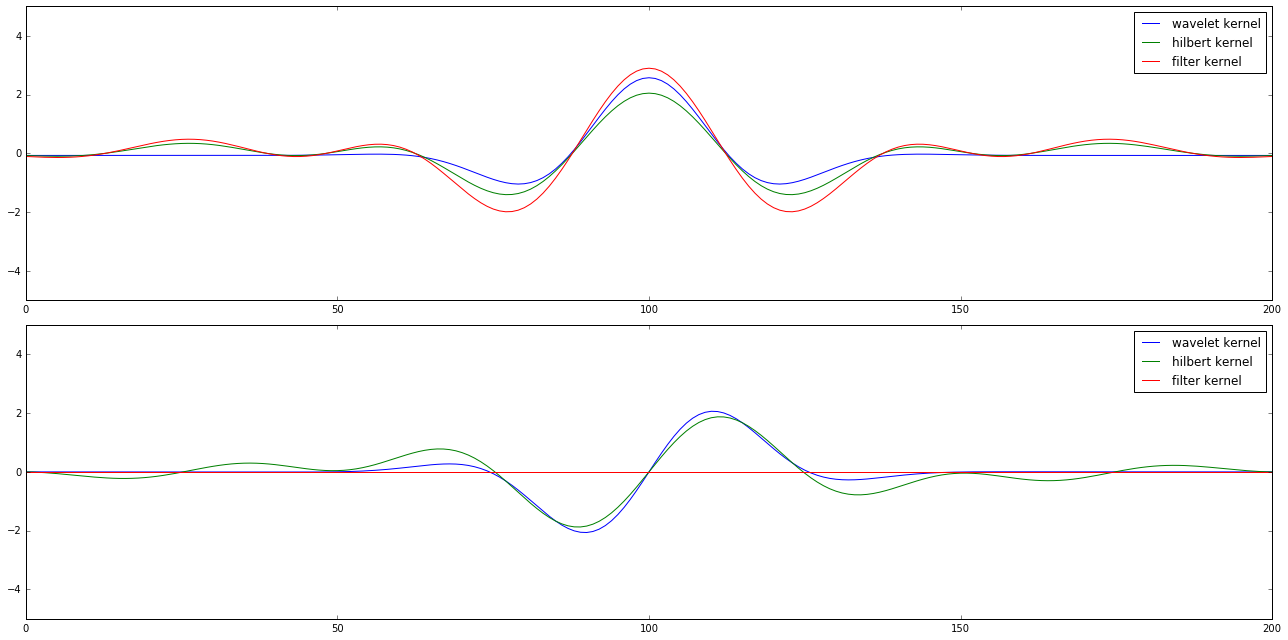

In [350]:
#plot wavelet and hilbert kernels
plt.figure(figsize=(18, 9))
plt.subplot(211)
plt.plot(real(waveletweights))
plt.plot(real(hilbertweights))
plt.plot(real(filterweights))
plt.legend(["wavelet kernel", 'hilbert kernel', "filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

plt.subplot(212)
plt.plot(imag(waveletweights))
plt.plot(imag(hilbertweights))
plt.plot(imag(filterweights))
plt.legend(["wavelet kernel", 'hilbert kernel', "filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

plt.tight_layout()

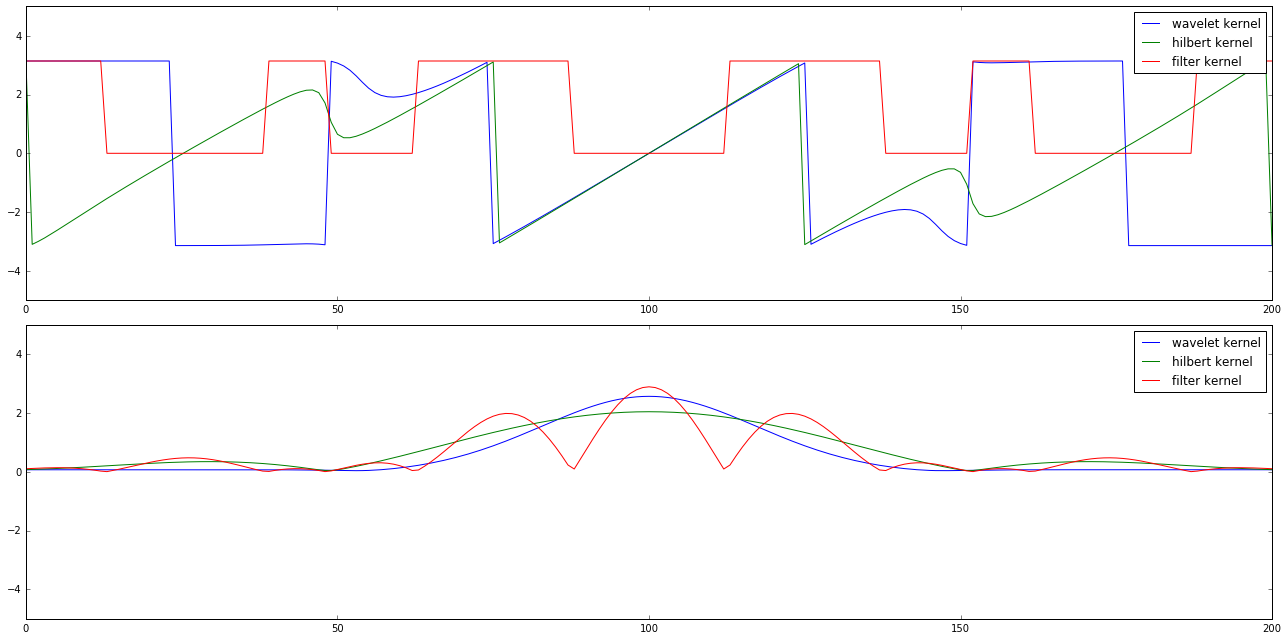

In [351]:
#plot wavelet and hilbert kernels
plt.figure(figsize=(18, 9))
plt.subplot(211)
plt.plot(angle(waveletweights))
plt.plot(angle(hilbertweights))
plt.plot(angle(filterweights))
plt.legend(["wavelet kernel", 'hilbert kernel', "filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

plt.subplot(212)
plt.plot(absolute(waveletweights))
plt.plot(absolute(hilbertweights))
plt.plot(absolute(filterweights))
plt.legend(["wavelet kernel", 'hilbert kernel', "filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

plt.tight_layout()

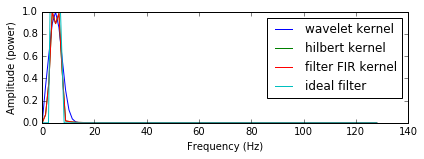

In [355]:
#plot wavelet and hilbert kernels
#plot power spectra
plt.subplot(212)
plt.plot(hz_filter, fft_wavelet[:int(ceil(len(fft_filter)/2.))])#[:(len(fft_wavelet)/2)])
plt.plot(hz_filter, fft_hilbert[:int(ceil(len(fft_filter)/2.))])
plt.plot(hz_filter, fft_filter[:int(ceil(len(fft_filter)/2.))])
plt.plot((ffrequencies*nyquist), idealresponse)
plt.legend(['wavelet kernel','hilbert kernel', 'filter FIR kernel', 'ideal filter'])
# plt.setp(plt.gca(),'ylim',[-.1, 1.1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (power)')
plt.tight_layout()